In [1]:
# ! pip install --user scikit-misc
import warnings

import xgboost as xgb
from sklearn.model_selection import train_test_split

warnings.simplefilter(action='ignore', )
warnings.simplefilter(action='ignore', )
import pandas as pd
import scanpy as sc
import anndata as ad
import seaborn as sns
import maxfuse as mf
import anndata
import hdbscan
from scipy.cluster.hierarchy import cut_tree
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, f1_score
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_mutual_info_score
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import mmread
from scipy import sparse
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

pd.set_option('display.max_rows', 10)  # Display only 10 rows
pd.set_option('display.max_columns', 5)  # Display only 5 columns

# setup and load datasets (only run once)
## CODEX

In [2]:
codex = sc.read(filename="/home/barroz/projects/Columbia/STAT_ML_GEN/project/codex_codex_cn_tumor.h5ad")
sc.pp.subsample(codex, fraction=0.03)
rna = sc.read(filename="/home/barroz/projects/Columbia/STAT_ML_GEN/project/scRNA-seq_rna_umap.h5ad")
sc.pp.subsample(rna, fraction=0.3)


In [3]:
adata_obs = codex  #sc.read_h5ad('codex.h5ad').obs
adata_obs = codex.obs

adata_obs.head()

,orig.ident,nCount_CODEX,...,condition,neighborhood
2849878,Longitudinal_Analysis,18291.1948,...,ICT,3
567160,Longitudinal_Analysis,16414.7984,...,CONTROL,2
473497,Longitudinal_Analysis,22362.7807,...,CONTROL,4
663789,Longitudinal_Analysis,11978.5676,...,CONTROL,7
2094541,Longitudinal_Analysis,22377.1193,...,ICT,4


In [4]:
# map neighborhood information (indices should match)
codex.obs['CN'] = adata_obs['neighborhood']

In [5]:
# FIX THIS
codex.obs['CN'] = codex.obs['CN'].replace({
    1: 'CN1 Tumor Boundary',
    2: 'CN2 Tumor Bulk',
    3: 'CN3 Neutrophils + Dead cells',
    4: 'CN4 CX3CR1+ Macrophage',
    5: 'CN5 Dead Cells Center',
    6: 'CN6 Lymphoid Rich',
    7: 'CN7 INOS+ and IFN-g Actv Macs',
}).astype('category')

In [6]:
rna.var['mf_features'] = \
sc.pp.highly_variable_genes(rna, n_top_genes=2000, batch_key=None, flavor='seurat_v3', layer='counts', inplace=False)[
    'highly_variable']

In [7]:
sc.tl.rank_genes_groups(rna, groupby='new_annotation', method='t-test')


In [8]:
print(np.sum(rna.var['mf_features']))
for ct in rna.obs['new_annotation'].unique():
    degs = sc.get.rank_genes_groups_df(rna, group=ct).iloc[:100, 0].values
    rna.var.loc[rna.var.index.isin(degs), 'mf_features'] = True
print(np.sum(rna.var['mf_features']))

2000
2340


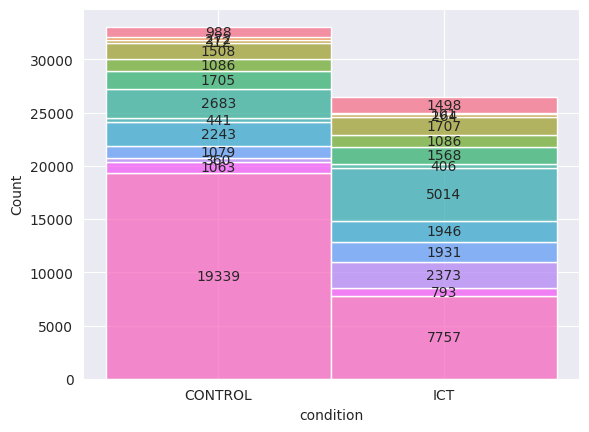

In [9]:
ax = sns.histplot(codex.obs, x='condition', hue='cell_type', multiple='stack', legend=False)
for container in ax.containers:
    ax.bar_label(container, label_type='center')

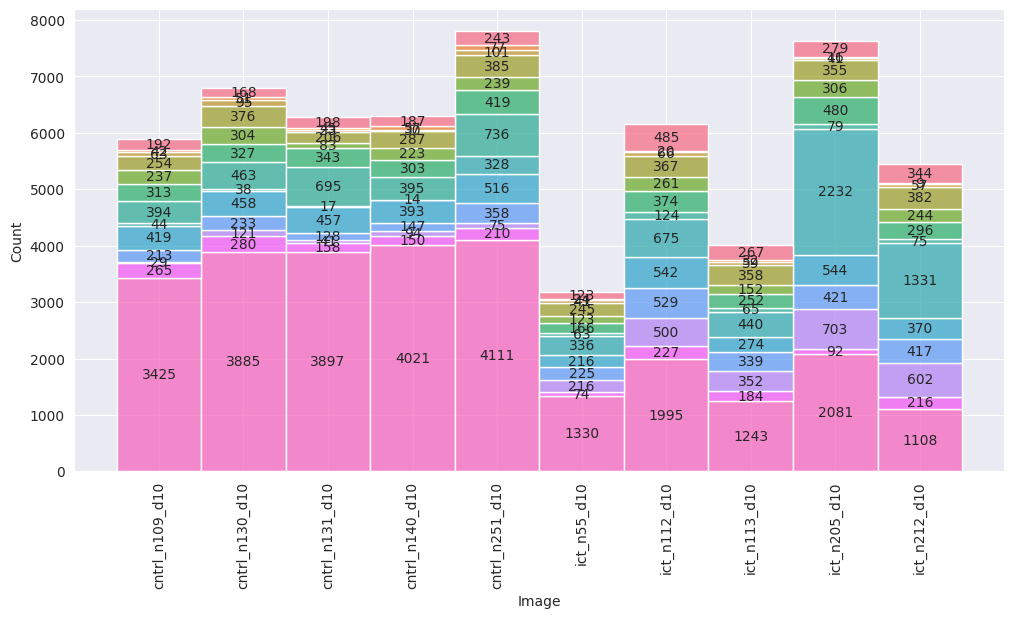

In [10]:
plt.subplots(figsize=(12, 6))
ax = sns.histplot(codex.obs, x='Image', hue='cell_type', multiple='stack', legend=False)
for container in ax.containers:
    ax.bar_label(container, label_type='center')
plt.xticks(rotation=90);

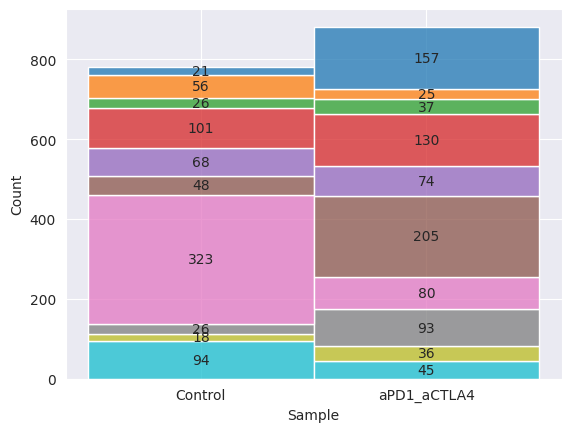

In [11]:
ax = sns.histplot(rna.obs, x='Sample', hue='new_annotation', multiple='stack', legend=False)
for container in ax.containers:
    ax.bar_label(container, label_type='center')

In [12]:
# from maxfuse repo
conversion = pd.read_csv('data/protein_gene_conversion.csv', index_col=0)


In [13]:
h_m_map = pd.read_csv('data/human2mouse.txt', sep='\t', index_col=0)
h_m_map.reset_index(inplace=True)

In [14]:
found_rna = []
not_found = []
for gene in codex.var_names:
    if gene.capitalize() in rna.var_names:
        found_rna.append(gene.capitalize())
    else:
        not_found.append(gene.capitalize())

In [15]:

found_h_m_map = []
for i, gene in enumerate(not_found):
    if gene.capitalize() in h_m_map['Mouse'].values:
        found_h_m_map.append(gene.capitalize())
        not_found.pop(i)

In [16]:
found_protein_conversion = []
for i, gene in enumerate(not_found):
    if gene in conversion.index.values:
        found_protein_conversion.append(gene + ':' + conversion.loc[gene, 'RNA name'])
        not_found.pop(i)

In [17]:
found_protein_conversion2 = []
for i, gene in enumerate(not_found):
    if gene.upper() in conversion.index.values:
        found_protein_conversion2.append(gene + ':' + conversion.loc[gene.upper(), 'RNA name'])
        not_found.pop(i)

In [18]:
print('found in rna:', found_rna)
print('needs human mapping:', found_h_m_map)
print('found_protein_conversion', found_protein_conversion)
print('found_protein_conversion2', found_protein_conversion2)
print(not_found)

found in rna: ['Foxp3', 'Cx3cr1', 'Xcr1', 'Gzmb', 'Cd4', 'Lag3', 'Cd38', 'Ly6g']
needs human mapping: []
found_protein_conversion ['Ki67:MKI67', 'Cd90:THY1']
found_protein_conversion2 ['Cd103:ITGAE', 'Cd3:CD3E/CD3D/CD3G', 'Pd1:PDCD1', 'Cd45:PTPRC/PTPRCAP', 'Cd31:PECAM1', 'Cd24:CD24', 'Pdl1:CD274']
['Cd140', 'Cd8', 'Nkp46', 'Tim 3', 'Sirp-alpha', 'Cd206', 'Caspase 3', 'Cd64', 'F4-80', 'Cd11c', 'Inos', 'Cd11b', 'Mhcii']


In [19]:
protein_mapping = {
    'cd103': 'Itgae',
    'ki67': 'Mki67',
    'foxp3': 'Foxp3',
    'cd140': 'Pdgfra',  # CD140 protein same as PDGFRA gene? 
    'cx3cr1': 'Cx3cr1',
    'cd3': 'Cd3d',  # or Cd3e or Cd3g 
    'cd8': 'Cd8b1',  # or Cd8a
    'nkp46': 'Ncr1',  # NKP46 protein same as NCR1 gene?
    'tim 3': 'Havcr2',  # TIM3 protein same as HAVCR2 gene?  
    'xcr1': 'Xcr1',
    'sirp-alpha': 'Sirpa',
    'gzmB': 'Gzmb',
    'pd1': 'Pdcd1',
    'cd206': 'Mrc1',
    'cd4': 'Cd4',
    'caspase 3': 'Casp3',
    'cd45': 'Ptprc',  # or Ptprcap
    'Lag3': 'Lag3',
    'cd64': 'Fcgr1',
    'f4-80': 'Adgre1',
    'cd38': 'Cd38',
    'cd31': 'Pecam1',
    'cd11c': 'Itgax',
    'cd24': 'Cd24a',
    'inos': 'Nos2',
    'cd11b': 'Itgam',
    'ly6G': 'Ly6g',
    'cd90': 'Thy1',
    'mhcii': None,
    # composed of HLA-DPA1, HLA-DPB1, HLA-DQA1, HLA-DQB1, HLA-DRA? # not including because biased towards treated condition in scRNA, vs. codex
    'pdL1': 'Cd274',
}

In [20]:
print(sorted(list(rna.var[rna.var_names.str.contains('H2')].index))[8:])

['H2-Aa', 'H2-Ab1', 'H2-D1', 'H2-DMa', 'H2-DMb1', 'H2-DMb2', 'H2-Eb1', 'H2-Eb2', 'H2-K1', 'H2-Ke6', 'H2-M2', 'H2-M3', 'H2-Oa', 'H2-Ob', 'H2-Q1', 'H2-Q10', 'H2-Q4', 'H2-Q6', 'H2-Q7', 'H2-T22', 'H2-T23', 'H2-T24', 'H2-T3', 'H2afj', 'H2afv', 'H2afx', 'H2afy', 'H2afy2', 'H2afz']


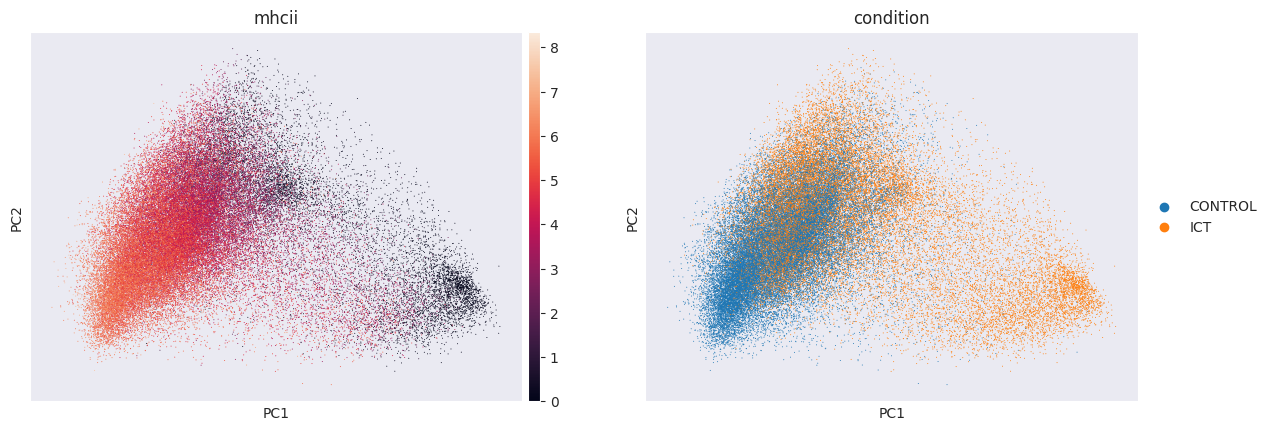

In [21]:
# run pca
sc.pp.pca(codex)
sc.pl.pca(codex, color=['mhcii', 'condition'])


In [22]:
protein_index = list()
RNA_index = list()
for protein in protein_mapping.keys():
    if protein_mapping[protein] != None:
        protein_index.append(protein)
        RNA_index.append(protein_mapping[protein])
print(protein_index)
print(RNA_index)

['cd103', 'ki67', 'foxp3', 'cd140', 'cx3cr1', 'cd3', 'cd8', 'nkp46', 'tim 3', 'xcr1', 'sirp-alpha', 'gzmB', 'pd1', 'cd206', 'cd4', 'caspase 3', 'cd45', 'Lag3', 'cd64', 'f4-80', 'cd38', 'cd31', 'cd11c', 'cd24', 'inos', 'cd11b', 'ly6G', 'cd90', 'pdL1']
['Itgae', 'Mki67', 'Foxp3', 'Pdgfra', 'Cx3cr1', 'Cd3d', 'Cd8b1', 'Ncr1', 'Havcr2', 'Xcr1', 'Sirpa', 'Gzmb', 'Pdcd1', 'Mrc1', 'Cd4', 'Casp3', 'Ptprc', 'Lag3', 'Fcgr1', 'Adgre1', 'Cd38', 'Pecam1', 'Itgax', 'Cd24a', 'Nos2', 'Itgam', 'Ly6g', 'Thy1', 'Cd274']


In [23]:
rna_shared = rna[:, RNA_index].copy()
codex_shared = codex[:, protein_index].copy()
print(rna_shared.shape)
print(codex_shared.shape)

(1663, 29)
(59523, 29)


In [24]:
protein_index = list()
RNA_index = list()
for protein in protein_mapping.keys():
    if protein_mapping[protein] != None:
        protein_index.append(protein)
        RNA_index.append(protein_mapping[protein])
print(protein_index[:5], '...')
print(RNA_index[:5], '...')

['cd103', 'ki67', 'foxp3', 'cd140', 'cx3cr1'] ...
['Itgae', 'Mki67', 'Foxp3', 'Pdgfra', 'Cx3cr1'] ...


In [25]:
# only 18 of the ~30 shared features are HVGs in scRNA-seq
rna_shared = rna[:, RNA_index].copy()
codex_shared = codex[:, protein_index].copy()
print(rna_shared.shape)
print(codex_shared.shape)
np.sum(rna_shared.var['mf_features'])


(1663, 29)
(59523, 29)


21

In [26]:
rna.var.loc[RNA_index, 'mf_features'] = True
rna_shared.var.loc[RNA_index, 'mf_features'] = True
print(np.sum(rna.var['mf_features']))

2348


In [27]:
sc.pp.neighbors(rna_shared, n_neighbors=15, use_rep='X')
sc.tl.umap(rna_shared)

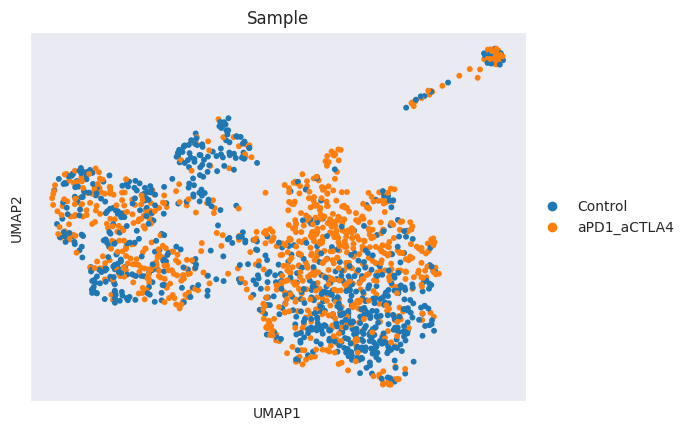

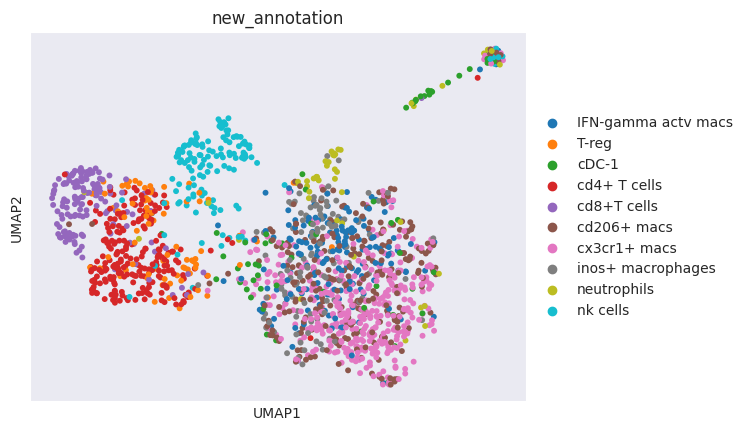

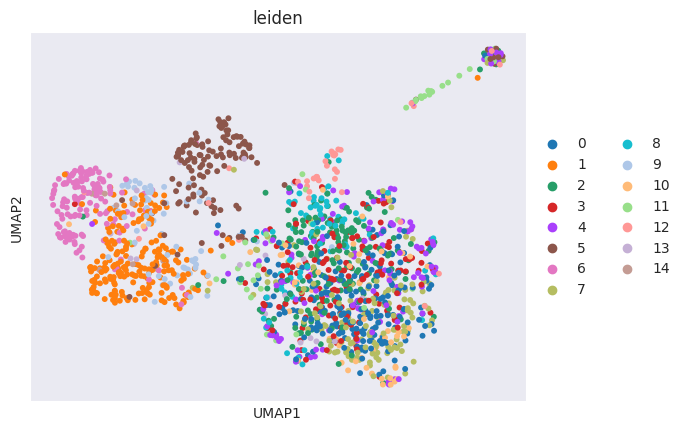

In [28]:
sc.pl.umap(rna_shared, color=['Sample'])
sc.pl.umap(rna_shared, color=['new_annotation'])
sc.pl.umap(rna_shared, color=['leiden'])

In [29]:
rna_shared = rna_shared.X.copy()
codex_shared = codex_shared.X.copy()

In [30]:
rna_active = rna[:, rna.var['mf_features']].copy()
sc.pp.scale(rna_active)  # preprocessing in the tutorial, makes it mean=0 and std var
rna_active = rna_active.X

In [31]:
codex_active = codex.copy()
# not sure if needed to scale protein measurements (they don't do it in tutorial, but the scale might be [0,1] based on methods section)
codex_active = codex.X

In [32]:
rna_active = np.asarray(rna_active)  # already dense numpy array
codex_active = np.asarray(codex_active.todense())
rna_shared = np.asarray(rna_shared.todense())
codex_shared = np.asarray(codex_shared.todense())

print(rna_active.shape)
print(codex_active.shape)
print(rna_shared.shape)
print(codex_shared.shape)

(1663, 2348)
(59523, 30)
(1663, 29)
(59523, 29)


# Fix MaxFuse

In [33]:
# use cell labels to guide MaxFuse smoothing steps
labels_rna = rna.obs['new_annotation'].values
labels_codex = codex.obs['cell_type'].values

display(labels_rna)
display(labels_codex)

['IFN-gamma actv macs', 'nk cells', 'cd4+ T cells', 'T-reg', 'neutrophils', ..., 'neutrophils', 'neutrophils', 'cd206+ macs', 'cd4+ T cells', 'cd4+ T cells']
Length: 1663
Categories (10, object): ['IFN-gamma actv macs', 'T-reg', 'cDC-1', 'cd4+ T cells', ..., 'cx3cr1+ macs', 'inos+ macrophages', 'neutrophils', 'nk cells']

['neutrophils', 'IFN-gamma actv macs', 'tumor', 'cx3cr1+ macs', 'inos+ macrophages', ..., 'endothelial cells', 'dead', 'cd8+T cells', 'tumor', 'dead']
Length: 59523
Categories (13, object): ['IFN-gamma actv macs', 'T-reg', 'cDC-1', 'cd4+ T cells', ..., 'inos+ macrophages', 'neutrophils', 'nk cells', 'tumor']

In [34]:
fusor = mf.model.Fusor(
    shared_arr1=rna_shared,
    active_arr1=rna_active,
    labels1=labels_rna,
    shared_arr2=codex_shared,
    active_arr2=codex_active,
    labels2=labels_codex,
)

In [35]:
# see tutorial for explanation -- the below reduces computational complexity
fusor.split_into_batches(
    max_outward_size=8000,
    matching_ratio=4,
    metacell_size=2,
    verbose=True
)

The first data is split into 1 batches, average batch size is 1663, and max batch size is 1663.
The second data is split into 1 batches, average batch size is 59523, and max batch size is 59523.
Batch to batch correspondence is:
  ['0<->0'].


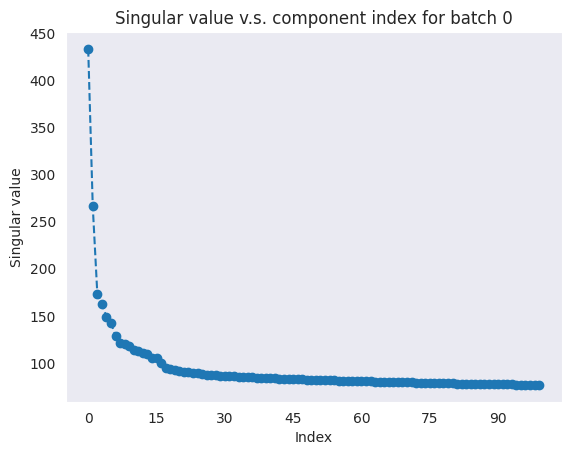

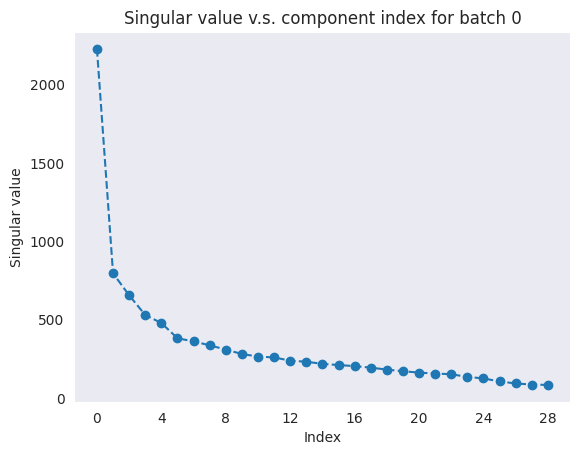

In [36]:
# plot top singular values of active_arr1 on a random batch
fusor.plot_singular_values(target='active_arr1',
                           n_components=None);  # can also explicitly specify the number of components
# plot top singular values of active_arr2 on a random batch
fusor.plot_singular_values(target='active_arr2', n_components=None);

In [37]:
svd_components1 = 40
svd_components2 = 15

fusor.construct_graphs(
    n_neighbors1=15,
    n_neighbors2=15,
    svd_components1=svd_components1,
    svd_components2=svd_components2,
    resolution1=2,
    resolution2=2,
    # if two resolutions differ less than resolution_tol
    # then we do not distinguish between then
    resolution_tol=0.1,
    verbose=True
)

Aggregating cells in arr1 into metacells of average size 2...
Constructing neighborhood graphs for cells in arr1...
Now at batch 0...
Graph construction finished!
Clustering into metacells...
Now at batch 0...
Metacell clustering finished!


In [38]:
svd_components1 = 20
svd_components2 = 20

fusor.find_initial_pivots(
    wt1=0.3, wt2=0.3,
    # weights of first and second modality; smaller = greater strength of fuzzy smoothing, 1 = original data used
    svd_components1=svd_components1, svd_components2=svd_components2)

Now at batch 0<->0...
Done!


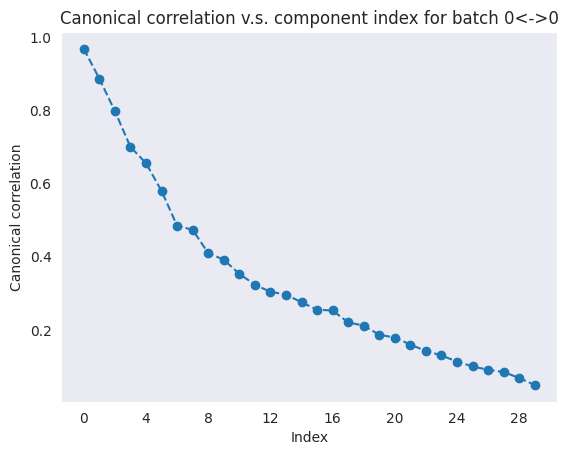

In [39]:
# plot top canonical correlations in a random batch
fusor.plot_canonical_correlations(
    svd_components1=40,
    svd_components2=None,
    cca_components=30
);

In [40]:
fusor.refine_pivots(
    wt1=0.3, wt2=0.3,
    svd_components1=40, svd_components2=None,
    cca_components=25,
    n_iters=1,
    randomized_svd=False,
    svd_runs=1,
    verbose=True
)

Now at batch 0<->0...
Done!


In [41]:
fusor.filter_bad_matches(target='pivot', filter_prop=0.5)  # 50% recommended by tutorial for spatial data

Begin filtering...
Now at batch 0<->0...
416/831 pairs of matched cells remain after the filtering.
Fitting CCA on pivots...
Scoring matched pairs...
849/1663 cells in arr1 are selected as pivots.
416/59523 cells in arr2 are selected as pivots.
Done!


In [42]:
# check performance based on cell type accuracy (pivot matching)
pivot_matching = fusor.get_matching(order=(2, 1), target='pivot')

lv1_acc = mf.metrics.get_matching_acc(matching=pivot_matching,
                                      labels1=labels_rna,
                                      labels2=labels_codex,
                                      order=(2, 1)
                                      )
lv1_acc

0.8894230769230769

In [43]:
fusor.propagate(
    svd_components1=40,
    svd_components2=None,
    wt1=0.7,
    wt2=0.7,
)

Now at batch 0<->0...
Done!


In [44]:
fusor.filter_bad_matches(target='propagated', filter_prop=0.3)  # recommended filter_prop between 0.1 - 0.4

Begin filtering...
Now at batch 0<->0...
41665/59522 pairs of matched cells remain after the filtering.
Scoring matched pairs...
Done!


In [45]:
full_matching = fusor.get_matching(order=(2, 1),
                                   target='full_data')  # we want rna (1) to match with multiple codex (2), not other way around

In [46]:
pd.DataFrame(list(zip(full_matching[0], full_matching[1], full_matching[2])),
             columns=['mod1_indx', 'mod2_indx', 'score'])
# columns: cell idx in mod1, cell idx in mod2, and matching scores

,mod1_indx,mod2_indx,score
0,67,20,0.479032
1,20,193,0.613461
2,1232,327,0.779955
3,1630,332,0.733179
4,1316,339,0.874214
...,...,...,...
42072,1363,59518,0.536653
42073,403,59519,0.492679
42074,1059,59520,0.667724
42075,661,59521,0.010003


In [47]:
# compute the cell type level matching accuracy, for the full (filtered version) dataset
lv1_acc = mf.metrics.get_matching_acc(matching=full_matching,
                                      labels1=labels_rna,
                                      labels2=labels_codex
                                      )
lv1_acc

0.25403427050407584

In [48]:
rna_embedding, codex_embedding = fusor.get_embedding(
    active_arr1=fusor.active_arr1,
    active_arr2=fusor.active_arr2
)
codex.obsm['X_maxfuse'] = codex_embedding

codex_embedding = anndata.AnnData(codex_embedding)
codex_embedding.obs = codex.obs
rna_embedding = anndata.AnnData(rna_embedding)
rna_embedding.obs = rna.obs
codex_embedding.write('codex_embedding.h5ad')
rna_embedding.write('rna_embedding.h5ad')


In [49]:
# num rna cell vs num codex cell
print(rna_embedding.shape)
print(codex_embedding.shape)


(1663, 25)
(59523, 25)


In [50]:

# Create an AnnData object combining RNA and CODEX cells in the shared space
rna_labels = ['RNA'] * rna_embedding.X.shape[0]
codex_labels = ['CODEX'] * codex_embedding.X.shape[0]
data_type_labels = np.concatenate([rna_labels, codex_labels])

combined_data = ad.AnnData(
    np.concatenate((rna_embedding.X, codex_embedding.X)),
    obs=pd.concat([rna.obs, codex.obs])
)
combined_data.obs['data_type'] = data_type_labels

# Perform UMAP on the combined data
# sc.pp.neighbors(combined_data, n_neighbors=15)
sc.tl.pca(combined_data)

# Plot the co-embedding
sample_fraction = 0.1
n_cells = combined_data.shape[0]
random_indices = np.random.choice(n_cells, size=int(n_cells * sample_fraction), replace=False)

# Subset the AnnData object to only include the sampled cells
sampled_data = combined_data[random_indices, :]
# sc.pl.pca(sampled_data, color=['Cluster', 'data_type'])



# Train a classifier on the co-embedding

In [51]:
# prepare data for training
features = codex_embedding.X
labels = codex_embedding.obs['CN']
labels = labels.astype('category').values.codes

In [52]:

X = pd.DataFrame(features)
y = pd.DataFrame(labels)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
score = f1_score(y_test, y_pred, average='weighted')
print(f'f1 score: {score:.4f}')

f1 score: 0.6317


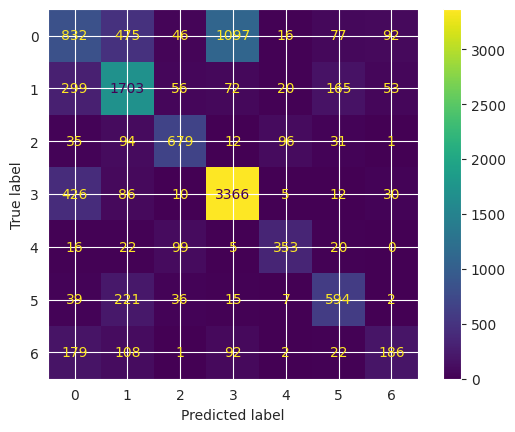

In [53]:
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()


# Prepare the RNA features

In [54]:
# prepare data for training
features = rna_embedding
labels = None

In [56]:
predicted_RNA_CN = model.predict(rna_embedding.X)

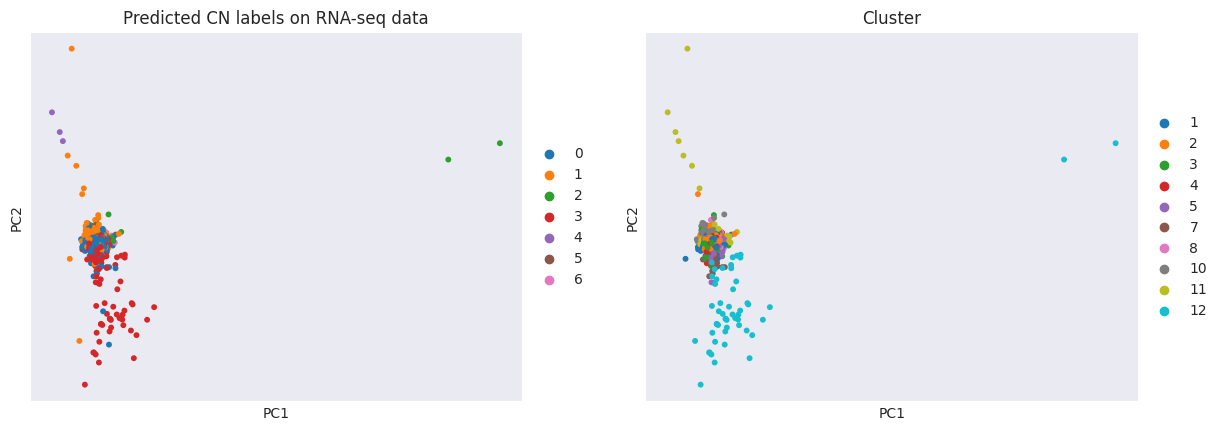

In [57]:
rna_embedding = anndata.AnnData(rna_embedding)
rna_embedding.obs = rna.obs
#  add the predicted CN labels to the RNA embedding
rna_embedding.obs['predicted_CN'] = pd.Categorical(predicted_RNA_CN)
# plot the RNA embedding with the predicted CN labels PCA
sc.tl.pca(rna_embedding)
# make the shape be the cell type
sc.pl.pca(rna_embedding, color=['predicted_CN', 'Cluster'], title='Predicted CN labels on RNA-seq data')

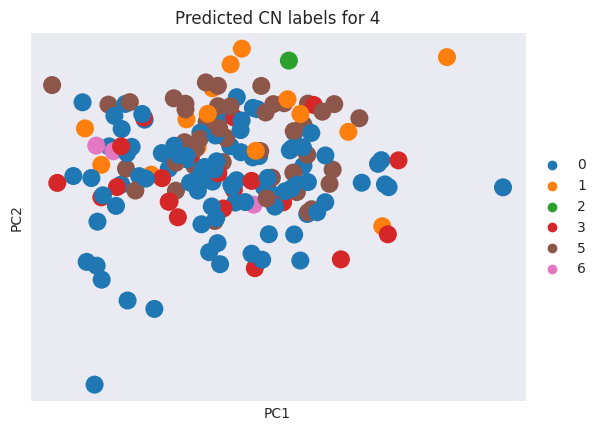

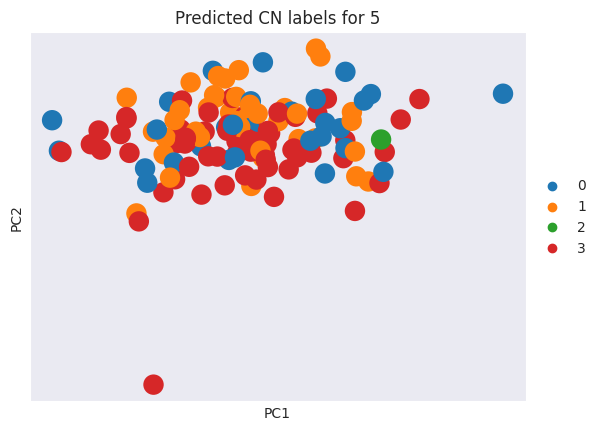

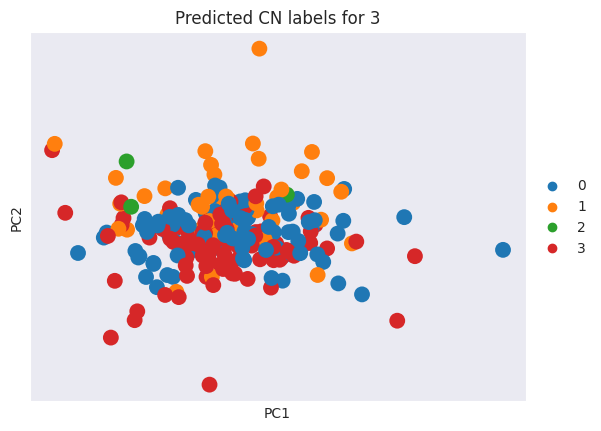

In [58]:
# Loop through each cluster and create a separate PCA plot
clusters = rna_embedding.obs['Cluster'].unique()[:3]
for cluster in clusters:
    subset_data = rna_embedding[rna_embedding.obs['Cluster'] == cluster]
    sc.pl.pca(subset_data, color='predicted_CN', title=f'Predicted CN labels for {cluster}')


In [59]:
# apply silhouette score on the predicted CN labels

# print results of all scores
print('Silhouette Score:', silhouette_score(rna_embedding.X, predicted_RNA_CN))
print('Calinski Harabasz Score:', calinski_harabasz_score(rna_embedding.X, predicted_RNA_CN))
print('Davies Bouldin Score:', davies_bouldin_score(rna_embedding.X, predicted_RNA_CN))



Silhouette Score: -0.018667757559438412
Calinski Harabasz Score: 27.319036230432214
Davies Bouldin Score: 4.298566558625326


In [60]:
num_clusters = len(np.unique(codex_embedding.obs['CN']))
gmm = GaussianMixture(n_components=num_clusters, random_state=0)
gmm_labels = gmm.fit_predict(rna_embedding.X)
ami_score = adjusted_mutual_info_score(rna_embedding.obs['predicted_CN'], gmm_labels)
rna_embedding.obs['GMM'] = pd.Categorical(gmm_labels)
print('Adjusted Mutual Information Score:', ami_score)

Adjusted Mutual Information Score: 0.11478421499670678


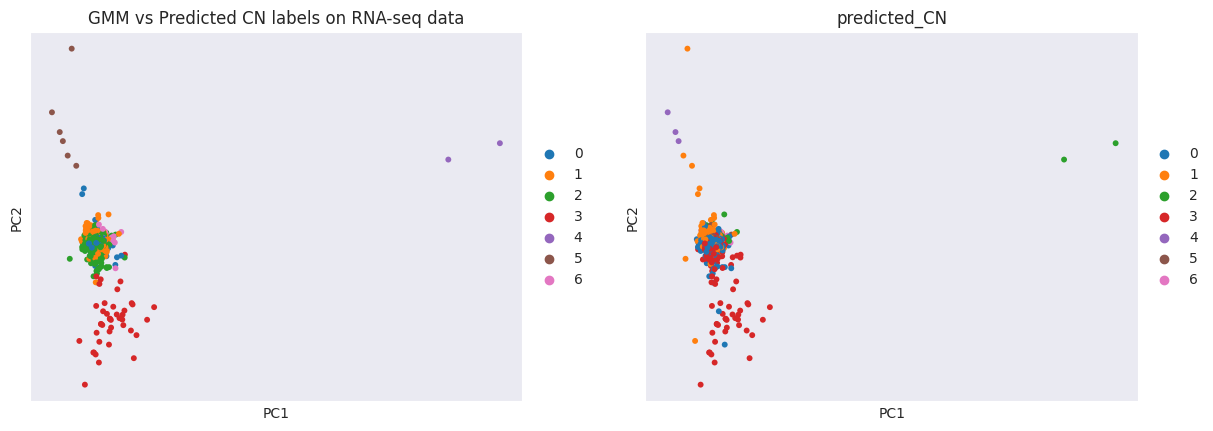

In [61]:
# plot the RNA embedding with the HDBSCAN labels vs the predicted CN labels
sc.pl.pca(rna_embedding, color=['GMM', 'predicted_CN'], title='GMM vs Predicted CN labels on RNA-seq data')

In [62]:

clusterer = hdbscan.HDBSCAN(min_cluster_size=2, gen_min_span_tree=True)
clusterer.fit(rna_embedding.X)
hierarchy = clusterer.single_linkage_tree_.to_numpy()
num_clusters = len(np.unique(codex_embedding.obs['CN']))
selected_clusters = cut_tree(hierarchy, n_clusters=num_clusters).flatten()
rna_embedding.obs['HDBSCAN_Cut'] = pd.Categorical(selected_clusters)
# Check mutual information score between predicted CN labels and the cut HDBSCAN labels
ami_score = adjusted_mutual_info_score(rna_embedding.obs['predicted_CN'], rna_embedding.obs['HDBSCAN_Cut'])
print('Adjusted Mutual Information Score:', ami_score)

Adjusted Mutual Information Score: 0.0059844738460516226


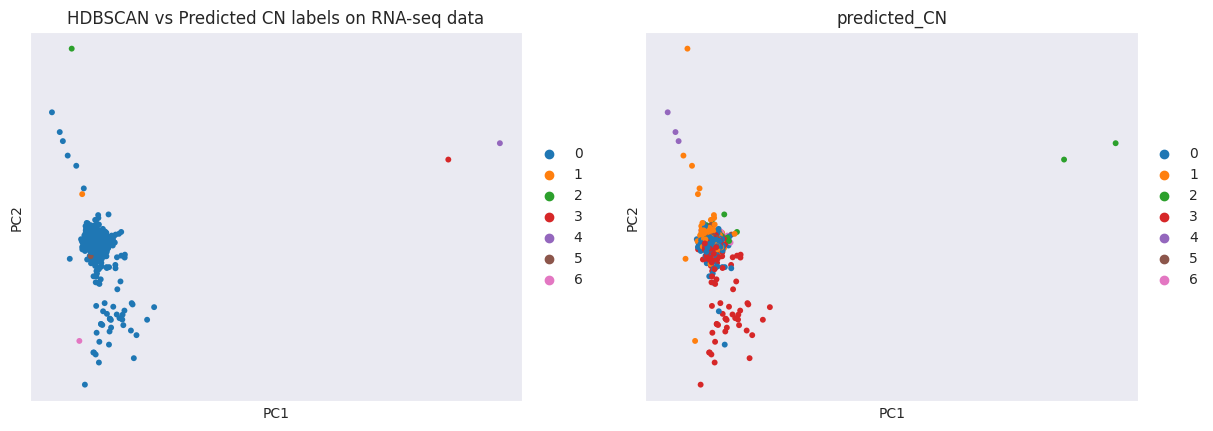

In [64]:
# plot the RNA embedding with the HDBSCAN labels vs the predicted CN labels
sc.pl.pca(rna_embedding, color=['HDBSCAN_Cut', 'predicted_CN'], title='HDBSCAN vs Predicted CN labels on RNA-seq data')